In [1]:
import numpy as np
import pandas as pd
from mgwr.mgwr.gwr import MGWR, GWR
from mgwr.mgwr.sel_bw import Sel_BW
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt



In [2]:
train_set = pd.read_csv('../../data/train_set_with_feat_unclean.csv')
test_set = pd.read_csv('../../data/test_set_with_feat_unclean.csv')

data = pd.concat([train_set])
data.head()

,id,mean_gs,sd,skewness,kurtosis,current_max,current_mean,current_min,gebco,x,...,y_im,x_im,x_m,y_m,slope,aspect,rough,bpi,shore_dist,current_range
0,1,2.48,1.33,3.70,24.33,0.164273,0.156398,0.146120,-227,-60.09194,...,724,915,186657.194374,335813.797226,14.389555,6.513883,124,-37,212225.813617,0.018153
1,2,4.15,1.82,2.34,9.43,0.116663,0.101989,0.092233,-17,-60.05735,...,642,924,188493.166778,297779.637872,0.061764,270.000000,4,0,181851.069142,0.024430
2,3,1.79,0.98,4.16,26.64,0.116663,0.101989,0.092233,-17,-60.05735,...,642,924,188493.166778,297779.637872,0.061764,270.000000,4,0,181851.069142,0.024430
3,4,1.58,0.75,5.16,45.76,0.106330,0.091203,0.081784,-18,-60.09058,...,642,916,186861.191308,297779.637872,0.061764,270.000000,2,0,179771.101828,0.024546
4,5,0.85,1.16,1.04,15.00,0.106330,0.091203,0.081784,-18,-60.08782,...,642,916,186861.191308,297779.637872,0.061764,270.000000,2,0,179771.101828,0.024546


In [3]:
print(list(data))
posibble_preds = list(data)
items_to_remove = ['id', 'mean_gs', 'sd', 'skewness', 'kurtosis', 'current_max', 'current_min','sample_type','y_im', 'x_im', 'x_m', 'y_m', 'current_mean', 'current_range', 'gebco', 'x', 'y']
#remove "base" as well
updated_list = [item for item in posibble_preds if item not in items_to_remove]

#data['current_range'] = data['current_max'] - data['current_min']
print(updated_list)

['id', 'mean_gs', 'sd', 'skewness', 'kurtosis', 'current_max', 'current_mean', 'current_min', 'gebco', 'x', 'y', 'sample_type', 'y_im', 'x_im', 'x_m', 'y_m', 'slope', 'aspect', 'rough', 'bpi', 'shore_dist', 'current_range']
['slope', 'aspect', 'rough', 'bpi', 'shore_dist']


In [4]:

predictors = ['current_mean', 'current_range', 'gebco']
response = 'mean_gs'


In [5]:

gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['x'], data['y']))
gdf = gdf.set_crs(epsg=4326)  # Assuming WGS84
gdf = gdf.to_crs(epsg=32633)  # Convert to UTM zone 33N

data['x'] = gdf.geometry.x
data['y'] = gdf.geometry.y
print(data['x'])


0      -5.036759e+06
1      -4.986116e+06
2      -4.986116e+06
3      -4.987333e+06
4      -4.987276e+06
            ...     
2105   -5.001167e+06
2106   -4.970671e+06
2107   -4.951021e+06
2108   -4.910076e+06
2109   -4.951217e+06
Name: x, Length: 2110, dtype: float64


In [6]:

coords = data[['x', 'y']].values
X = data[predictors].values
y = data[response].values.reshape(-1, 1)


In [7]:
import itertools

combinations = []
for r in range(0, len(updated_list) + 1):
    combinations.extend(itertools.combinations(updated_list, r))

# Add each combination to A
pred_result = [predictors + list(comb) for comb in combinations]

In [16]:
res_dict = dict()
for pred in range(len(pred_result)):
    predictorsN = pred_result[pred]
    print(predictorsN)
    X = data[predictorsN].values
    y = data[response].values.reshape(-1, 1)
    selector = Sel_BW(coords, y, X, multi=False) # This creates the bandwidths for different input features
    bws = selector.search(verbose=True, search_method='golden_section', max_iter=100) # This searches for the optimal bandwidth (fields of influence)
    mgwr_model = GWR(coords, y, X, bws)
    results = mgwr_model.fit() # This fits the model to the data
    res_dict[pred] = results.adj_R2

['current_mean', 'current_range', 'gebco']



KeyboardInterrupt



In [ ]:
print(data[predictorsN].describe())
print(data[response].isnull().any())
print(data[response].describe())

In [ ]:
for j in res_dict:
    print(j)
    print(res_dict[j])



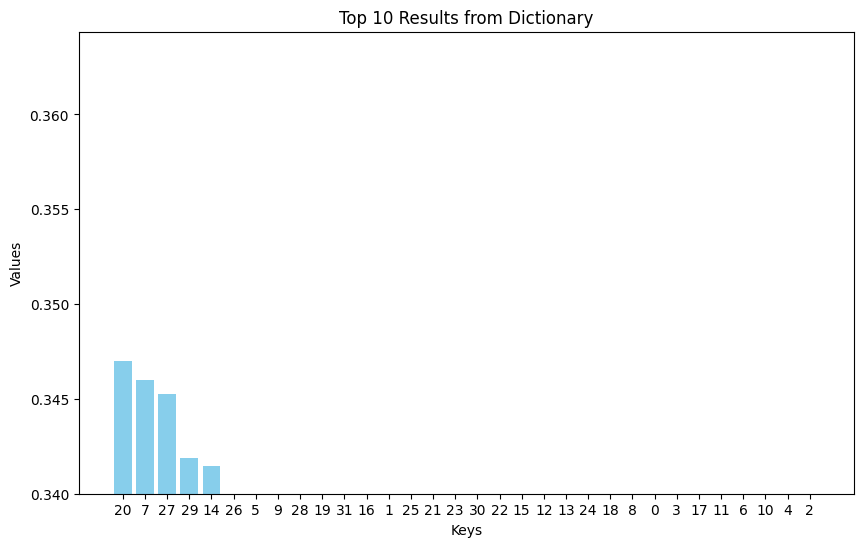

In [9]:
results = res_dict
# Number of top results to show
x = 10

# Sort the dictionary by values in descending order and get the top `x` results
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))


# Extract keys and values from the sorted dictionary
keys = list(sorted_results.keys())
keys_str = [str(x) for x in keys]

values = list(sorted_results.values())

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(keys_str, values, color='skyblue')
plt.ylim(0.34) 
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title(f'Top {x} Results from Dictionary')
plt.show()


In [10]:
# Find best combination
print(pred_result[list(sorted_results.keys())[0]])
print(list(sorted_results.keys())[0])

['current_mean', 'current_range', 'gebco', 'slope', 'rough', 'shore_dist']
20


In [11]:
predictorsN = pred_result[list(sorted_results.keys())[0]]
print(predictorsN)
X = data[predictorsN].values
y = data[response].values.reshape(-1, 1)

['current_mean', 'current_range', 'gebco', 'slope', 'rough', 'shore_dist']


In [ ]:
selector = Sel_BW(coords, y, X, multi=False) # This creates the bandwidths for different input features
bws = selector.search(verbose=True, search_method='golden_section', max_iter=100) # This searches for the optimal bandwidth (fields of influence)
mgwr_model = GWR(coords, y, X, bws)
results = mgwr_model.fit() # This fits the model to the data
#print(results.summary()) # This prints the summary of the model fit
print(results.R2)


In [ ]:
print(results.summary())

In [13]:
test_data = test_set
test_gdf = gpd.GeoDataFrame(test_data, geometry=gpd.points_from_xy(test_data['x'], test_data['y']))
test_gdf = test_gdf.set_crs(epsg=4326)
test_gdf = test_gdf.to_crs(epsg=32633)

test_data['x'] = test_gdf.geometry.x
test_data['y'] = test_gdf.geometry.y


In [ ]:

#test_data['current_range'] = test_data['current_max'] - test_data['current_min']


In [ ]:
top_cand = 1
for j in range(top_cand):
    predictorsN = pred_result[list(sorted_results.keys())[j]]
    print(predictorsN)
    X = data[predictorsN].values
    y = data[response].values.reshape(-1, 1)
    test_coords = test_data[['x', 'y']].values
    test_X = test_data[predictorsN].values
    selector = Sel_BW(coords, y, X, multi=False) # This creates the bandwidths for different input features
    bws = selector.search(verbose=True, search_method='golden_section', max_iter=100) # This searches for the optimal bandwidth (fields of influence)
    mgwr_model = GWR(coords, y, X, bws)
    results = mgwr_model.fit() # This fits the model to the data
    #print(results.summary()) # This prints the summary of the model fit
    print(results.R2)
    scale = results.scale
    residuals = results.resid_response
    test_data['mean_gs'] = mgwr_model.predict(test_coords, test_X, scale, residuals).predictions # This predicts the response variable for the test data using the fitted model
    submission = test_data[['id', 'mean_gs']]
    submission.to_csv(f'../../data/submission/test_submission_mgwr_{list(sorted_results.keys())[j]}_unclean.csv', index=False)


['current_mean', 'current_range', 'gebco', 'slope', 'rough', 'shore_dist']
Bandwidth:  839.0 , score:  9808.74
Bandwidth:  1325.0 , score:  9862.29
Bandwidth:  539.0 , score:  9770.04
Bandwidth:  354.0 , score:  9705.63
Bandwidth:  239.0 , score:  9688.25
Bandwidth:  169.0 , score:  9693.23
Bandwidth:  283.0 , score:  9694.27
Bandwidth:  213.0 , score:  9688.83
Bandwidth:  256.0 , score:  9689.97
Bandwidth:  229.0 , score:  9687.70
Bandwidth:  223.0 , score:  9687.44
Bandwidth:  219.0 , score:  9687.90
Bandwidth:  225.0 , score:  9687.51
Bandwidth:  221.0 , score:  9687.32
0.38921718408412287


In [ ]:
j=4
print(list(sorted_results.keys())[j])
print(pred_result[list(sorted_results.keys())[j]])


In [ ]:
scale = results.scale
residuals = results.resid_response
test_data['mean_gs'] = mgwr_model.predict(test_coords, test_X, scale, residuals).predictions # This predicts the response variable for the test data using the fitted model


In [ ]:

submission = test_data[['id', 'mean_gs']]
#submission.to_csv('test_submission_mgwr.csv', index=False)


Data saved to feature_coding.csv
